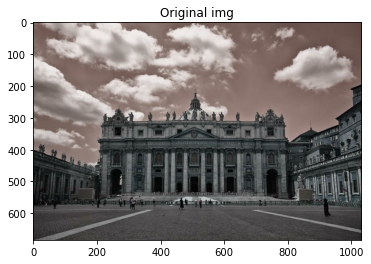

theta: 33.15879424509406
R:
[[ 0.99550292 -0.02668501 -0.09089468]
 [-0.02668501  0.84165497 -0.53935593]
 [ 0.09089468  0.53935593  0.83715789]]
R:
[[ 0.99550292 -0.02668501 -0.09089468]
 [-0.02668501  0.84165497 -0.53935593]
 [ 0.09089468  0.53935593  0.83715789]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99550292 -0.02668501 -0.09089468]
 [-0.02668501  0.84165497 -0.53935593]
 [ 0.09089468  0.53935593  0.83715789]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.05135406e+00  3.04727592e-01 -2.91071945e+02]
 [ 1.03326008e-02  1.06131216e+00 -5.34922913e+02]
 [ 1.08238642e-04  6.42272495e-04  5.61649559e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99550292 -0.02668501 -0.09089468]
 [-0.02668501  0.84165497 -0.53935593]
 [ 0.09089468  0.53935593  0.83715789]],
K_inv: [[ 0.00119081  0.         -0.614459

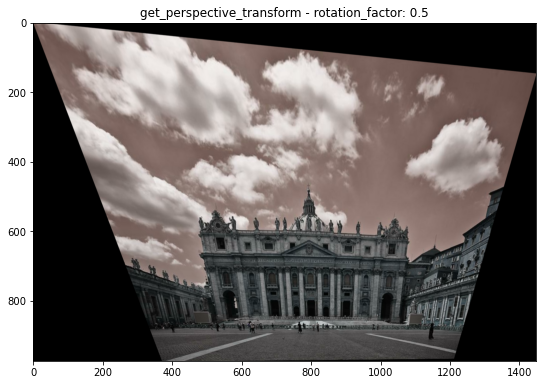

theta: 36.47467366960347
R:
[[ 0.99459053 -0.032099   -0.0987893 ]
 [-0.032099    0.80952918 -0.58620147]
 [ 0.0987893   0.58620147  0.80411971]]
R:
[[ 0.99459053 -0.032099   -0.0987893 ]
 [-0.032099    0.80952918 -0.58620147]
 [ 0.0987893   0.58620147  0.80411971]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99459053 -0.032099   -0.0987893 ]
 [-0.032099    0.80952918 -0.58620147]
 [ 0.0987893   0.58620147  0.80411971]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.05529260e+00  3.28098316e-01 -3.24774322e+02]
 [ 8.13376801e-03  1.04826461e+00 -5.79964206e+02]
 [ 1.17639666e-04  6.98056810e-04  5.04682214e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99459053 -0.032099   -0.0987893 ]
 [-0.032099    0.80952918 -0.58620147]
 [ 0.0987893   0.58620147  0.80411971]],
K_inv: [[ 0.00119081  0.         -0.614459

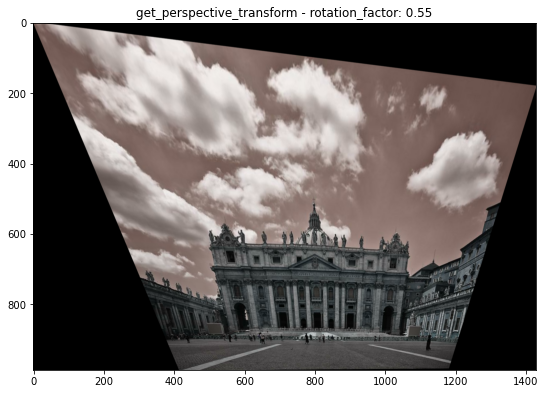

theta: 39.79055309411287
R:
[[ 0.99360379 -0.0379542  -0.10635314]
 [-0.0379542   0.77478527 -0.6310842 ]
 [ 0.10635314  0.6310842   0.76838905]]
R:
[[ 0.99360379 -0.0379542  -0.10635314]
 [-0.0379542   0.77478527 -0.6310842 ]
 [ 0.10635314  0.6310842   0.76838905]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99360379 -0.0379542  -0.10635314]
 [-0.0379542   0.77478527 -0.6310842 ]
 [ 0.10635314  0.6310842   0.76838905]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.05895353e+00  3.49821756e-01 -3.58881621e+02]
 [ 5.35900462e-03  1.03179956e+00 -6.22812071e+02]
 [ 1.26646790e-04  7.51503786e-04  4.46025016e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99360379 -0.0379542  -0.10635314]
 [-0.0379542   0.77478527 -0.6310842 ]
 [ 0.10635314  0.6310842   0.76838905]],
K_inv: [[ 0.00119081  0.         -0.614459

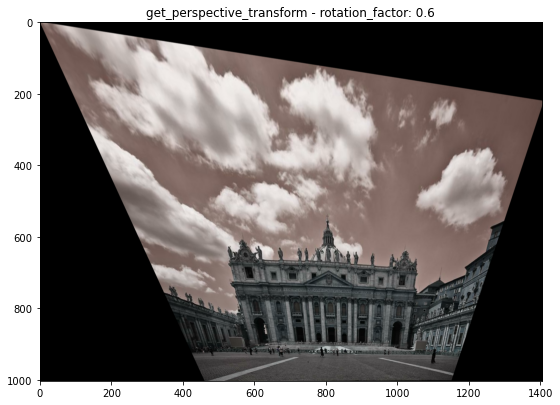

theta: 43.10643251862228
R:
[[ 0.99254599 -0.04423101 -0.11356087]
 [-0.04423101  0.73753957 -0.67385384]
 [ 0.11356087  0.67385384  0.73008556]]
R:
[[ 0.99254599 -0.04423101 -0.11356087]
 [-0.04423101  0.73753957 -0.67385384]
 [ 0.11356087  0.67385384  0.73008556]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99254599 -0.04423101 -0.11356087]
 [-0.04423101  0.73753957 -0.67385384]
 [ 0.11356087  0.67385384  0.73008556]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.06232460e+00  3.69825174e-01 -3.93279640e+02]
 [ 2.01760152e-03  1.01197216e+00 -6.63323041e+02]
 [ 1.35229856e-04  8.02434463e-04  3.85874370e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99254599 -0.04423101 -0.11356087]
 [-0.04423101  0.73753957 -0.67385384]
 [ 0.11356087  0.67385384  0.73008556]],
K_inv: [[ 0.00119081  0.         -0.614459

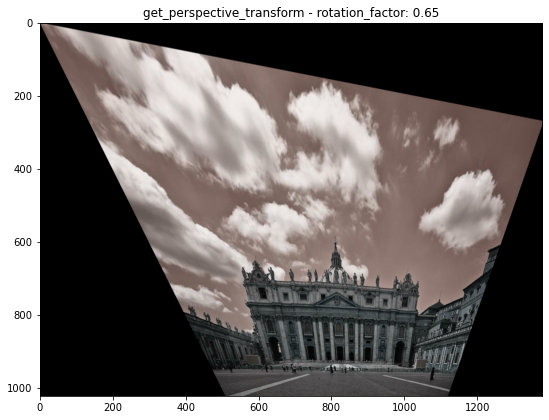

theta: 46.42231194313169
R:
[[ 0.99142069 -0.05090842 -0.12038836]
 [-0.05090842  0.6979168  -0.71436718]
 [ 0.12038836  0.71436718  0.68933749]]
R:
[[ 0.99142069 -0.05090842 -0.12038836]
 [-0.05090842  0.6979168  -0.71436718]
 [ 0.12038836  0.71436718  0.68933749]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99142069 -0.05090842 -0.12038836]
 [-0.05090842  0.6979168  -0.71436718]
 [ 0.12038836  0.71436718  0.68933749]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.06539451e+00  3.88041591e-01 -4.27853201e+02]
 [-1.87925312e-03  9.88848783e-01 -7.01361469e+02]
 [ 1.43360125e-04  8.50678309e-04  3.24431680e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99142069 -0.05090842 -0.12038836]
 [-0.05090842  0.6979168  -0.71436718]
 [ 0.12038836  0.71436718  0.68933749]],
K_inv: [[ 0.00119081  0.         -0.614459

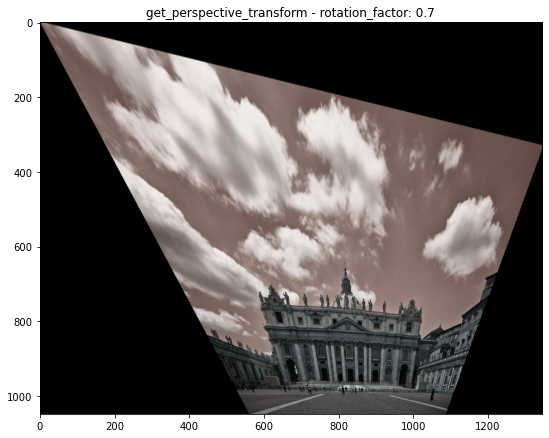

theta: 49.738191367641086
R:
[[ 0.99023164 -0.05796406 -0.12681275]
 [-0.05796406  0.65604963 -0.75248857]
 [ 0.12681275  0.75248857  0.64628127]]
R:
[[ 0.99023164 -0.05796406 -0.12681275]
 [-0.05796406  0.65604963 -0.75248857]
 [ 0.12681275  0.75248857  0.64628127]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99023164 -0.05796406 -0.12681275]
 [-0.05796406  0.65604963 -0.75248857]
 [ 0.12681275  0.75248857  0.64628127]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.06815299e+00  4.04410014e-01 -4.62486542e+02]
 [-6.31851125e-03  9.62506865e-01 -7.36799990e+02]
 [ 1.51010375e-04  8.96073785e-04  2.61902680e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.99023164 -0.05796406 -0.12681275]
 [-0.05796406  0.65604963 -0.75248857]
 [ 0.12681275  0.75248857  0.64628127]],
K_inv: [[ 0.00119081  0.         -0.61445

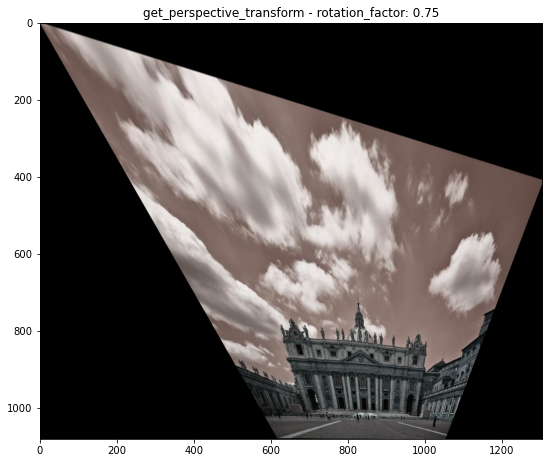

theta: 53.05407079215049
R:
[[ 0.98898283 -0.06537431 -0.13281252]
 [-0.06537431  0.61207825 -0.78809036]
 [ 0.13281252  0.78809036  0.60106107]]
R:
[[ 0.98898283 -0.06537431 -0.13281252]
 [-0.06537431  0.61207825 -0.78809036]
 [ 0.13281252  0.78809036  0.60106107]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98898283 -0.06537431 -0.13281252]
 [-0.06537431  0.61207825 -0.78809036]
 [ 0.13281252  0.78809036  0.60106107]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07059080e+00  4.18875633e-01 -4.97063696e+02]
 [-1.12853087e-02  9.33034606e-01 -7.69519943e+02]
 [ 1.58154988e-04  9.38468891e-04  1.98496738e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98898283 -0.06537431 -0.13281252]
 [-0.06537431  0.61207825 -0.78809036]
 [ 0.13281252  0.78809036  0.60106107]],
K_inv: [[ 0.00119081  0.         -0.614459

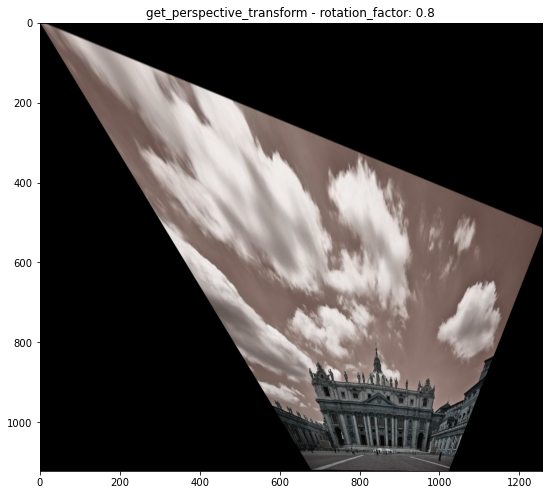

theta: 56.36995021665991
R:
[[ 0.98767844 -0.07311437 -0.13836759]
 [-0.07311437  0.56614987 -0.82105335]
 [ 0.13836759  0.82105335  0.55382831]]
R:
[[ 0.98767844 -0.07311437 -0.13836759]
 [-0.07311437  0.56614987 -0.82105335]
 [ 0.13836759  0.82105335  0.55382831]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98767844 -0.07311437 -0.13836759]
 [-0.07311437  0.56614987 -0.82105335]
 [ 0.13836759  0.82105335  0.55382831]],
K_inv: [[ 0.00119081  0.         -0.61445993]
 [ 0.          0.00119081 -0.40725832]
 [ 0.          0.          1.        ]]
original P:
[[ 1.07269978e+00  4.31390014e-01 -5.31468888e+02]
 [-1.67630148e-02  9.00530687e-01 -7.99411771e+02]
 [ 1.64770043e-04  9.77721674e-04  1.34426159e-01]]
K:
[[839.76184082, 0.0, 516.0], [0.0, 839.76184082, 342.0], [0.0, 0.0, 1.0]],
R:
[[ 0.98767844 -0.07311437 -0.13836759]
 [-0.07311437  0.56614987 -0.82105335]
 [ 0.13836759  0.82105335  0.55382831]],
K_inv: [[ 0.00119081  0.         -0.614459

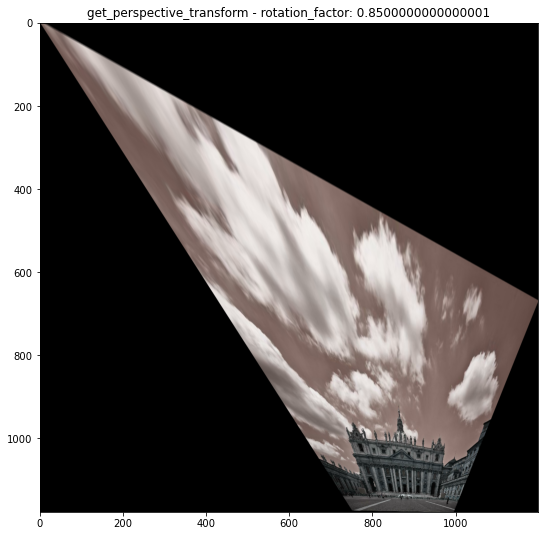

In [ ]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math


def make_homogeneous(column_vecs):
    return np.vstack((column_vecs, np.ones(column_vecs.shape[1])))


def get_rotation_matrix(unit_rotation_vector, theta):

    # Rodrigues formula
    # R = I + sin(theta) . K + (1 - cos(theta)).K**2

    K = np.array([
        [0.0, -unit_rotation_vector[2], unit_rotation_vector[1]],
        [unit_rotation_vector[2], 0.0, -unit_rotation_vector[0]],
        [-unit_rotation_vector[1], unit_rotation_vector[0], 0.0],
    ])
    a = np.eye(3)
    b = math.sin(theta) * K
    c = (1.0 - math.cos(theta)) * K @ K

    R = a + b + c
    return R


def get_rectification_rotation(normal, rotation_factor=1.0):

    # now the normals will be "from the camera", "inside" the surfaces
    normal = -normal

    z = np.array([0.0, 0.0, 1.0])

    rotation_vector = np.cross(normal, z)
    rotation_vector_norm = abs_sin_theta = np.linalg.norm(rotation_vector)
    unit_rotation_vector = rotation_vector / rotation_vector_norm
    theta = math.asin(abs_sin_theta) * rotation_factor
    print("theta: {}".format(theta * 180 / math.pi))

    R = get_rotation_matrix(unit_rotation_vector, theta)
    det = np.linalg.det(R)
    assert math.fabs(det - 1.0) < 0.0001
    print("R:\n{}".format(R))
    return R


def show_transormation(K, normal):
    
    for t in range(20):
        rotation_factor=0.5 + t * 0.05

        R = get_rectification_rotation(normal, rotation_factor=rotation_factor)
        print("R:\n{}".format(R))

        T, bounding_box = get_perspective_transform(R, K)

        rectified = cv.warpPerspective(img, T, bounding_box)

        plt.figure(figsize=(9, 9))
        plt.title("get_perspective_transform - rotation_factor: {}".format(rotation_factor))
        plt.imshow(rectified)
        plt.show()



def get_perspective_transform(R, K):
    
    scale = 1.0
    
    K_inv = np.linalg.inv(K)

    unscaled = True
    while unscaled:

        coords = np.where(img[:, :, 0] > 0)
        coords = np.array([coords[1], coords[0]])
        coords = make_homogeneous(coords)

        # I really think I need K (even if estimated)
        print("K:\n{},\nR:\n{},\nK_inv: {}".format(K, R, K_inv))
        P = K @ R @ K_inv
        print("original P:\n{}".format(P))
        if scale != 1.0:
            unscaled = False
            #scale = scale * 10
            print("scale: {}".format(scale))
            P[:2, :] *= scale

        new_coords = P @ coords
        new_coords = new_coords / new_coords[2, :]

        min_row = min(new_coords[1])
        max_row = max(new_coords[1])
        min_col = min(new_coords[0])
        max_col = max(new_coords[0])

        dst = np.float32([[min_col, min_row], [min_col, max_row - 1], [max_col - 1, max_row - 1], [max_col - 1, min_row]])
        dst = np.transpose(dst)
        dst = make_homogeneous(dst)

        if unscaled:
            new_bb_size = (max_row - min_row) * (max_col - min_col)
            scale = np.sqrt((coords.shape[1] * 2.0) / new_bb_size)
            if scale == 1.0:
                unscaled = False
                break


    translate_vec_new = (-np.min(dst[0]), -np.min(dst[1]))

    translate_matrix = np.array([
        [1, 0, translate_vec_new[0]],
        [0, 1, translate_vec_new[1]],
        [0, 0, 1],
    ])


    dst = translate_matrix @ dst
    print("scaled P:\n{}".format(P))
    print("translate_matrix:\n{}".format(translate_matrix))
    P = translate_matrix @ P
    print("new P:\n{}".format(P))
    bounding_box = (math.ceil(np.max(dst[0])), math.ceil(np.max(dst[1])))
    print("bounding box: {}".format(bounding_box))
    
    return P, bounding_box
    
img = cv.imread("phototourism/st_peters_square/set_100/images/99261069_5958624644.jpg", None)
plt.figure()
plt.title("Original img")
plt.imshow(img)
plt.show()

K = [[839.76184082,  0.,  516.], 
     [  0.,          839.76184082,  342.], 
     [  0.,          0.,        1.]]


normal = np.array([-0.1521864, -0.90305215, 0.40166667])

# rotation around x axis
# y = -0.9
# z = math.sqrt(1.0 - y**2)
# normal = np.array([0.0, y, z])

show_transormation(K, normal)

